In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Simulate an AR(2) process and make forecasts 

In [2]:
np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

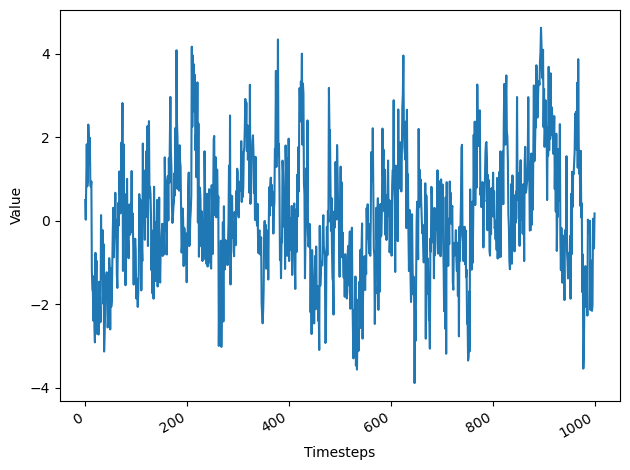

In [3]:
fig, ax = plt.subplots()

ax.plot(AR2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ADF_result = adfuller(AR2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.56660602141691
p-value: 2.9145161293762146e-11


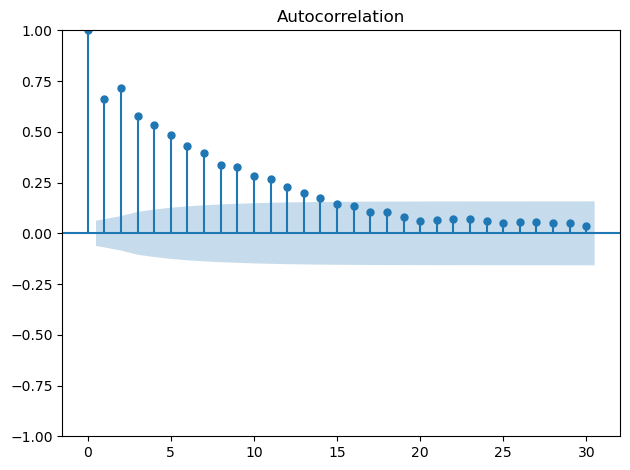

In [5]:
plot_acf(AR2_process, lags=30);

plt.tight_layout()

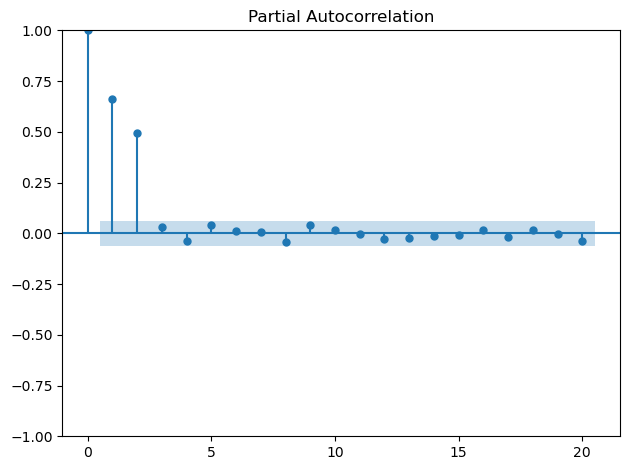

In [7]:
plot_pacf(AR2_process, lags=20);

plt.tight_layout()

In [8]:
df = pd.DataFrame({'value': AR2_process})

train = df[:800]
test = df[800:]

In [9]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [10]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,value,pred_mean,pred_last_value,pred_AR
800,1.153388,-0.049737,0.461912,0.208203
801,0.095529,-0.049737,0.461912,0.289199
802,0.704340,-0.048056,0.095529,0.586307
803,-0.182079,-0.048056,0.095529,0.233598
804,-0.142412,-0.047287,-0.182079,0.281393


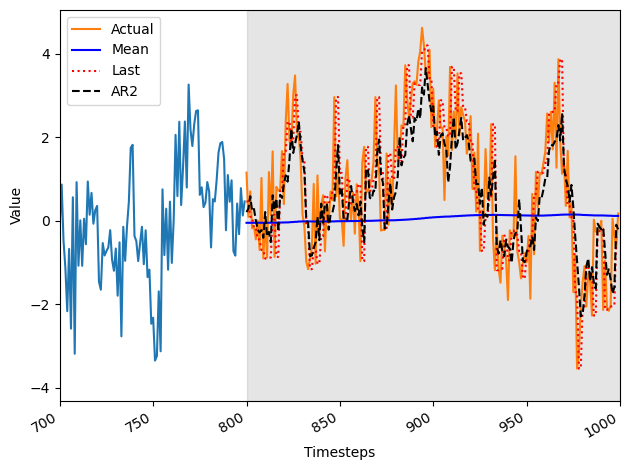

In [11]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_AR'], 'k--', label='AR2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

In [12]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_AR = mean_squared_error(test['value'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.0882016808214443 1.2111519051869672 0.9692635186571182


The AR(2) model achieves the lowest MSE and is therefore the champion model.

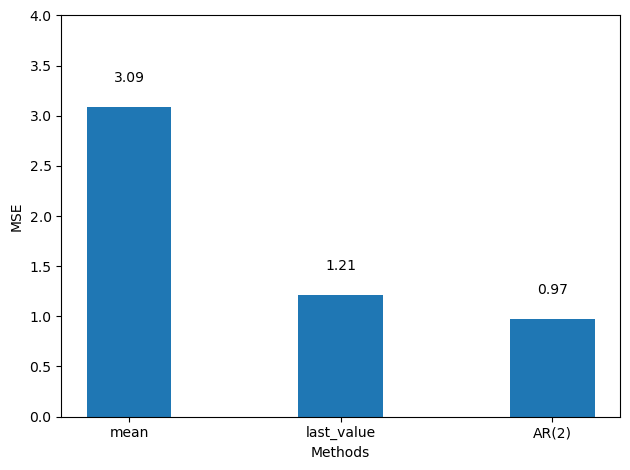

In [13]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

## Simulate an AR(p) process and make forecasts 

In [14]:
np.random.seed(42)

ma3 = np.array([1, 0, 0, 0])
ar3 = np.array([1, -0.33, -0.50, -0.07])

AR3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

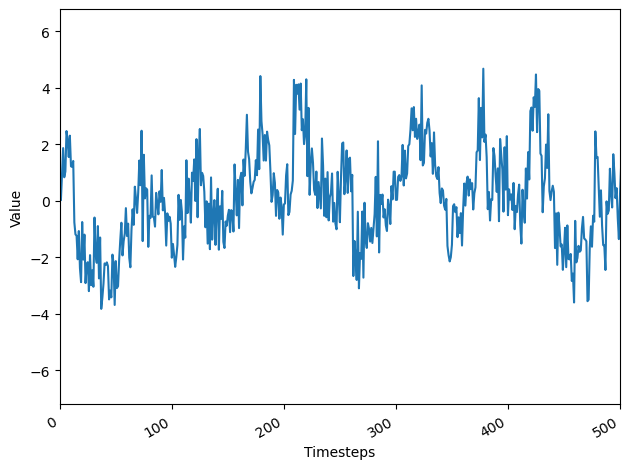

In [15]:
fig, ax = plt.subplots()

ax.plot(AR3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
ADF_result = adfuller(AR3_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -17.4322927352144
p-value: 4.759612221579044e-30


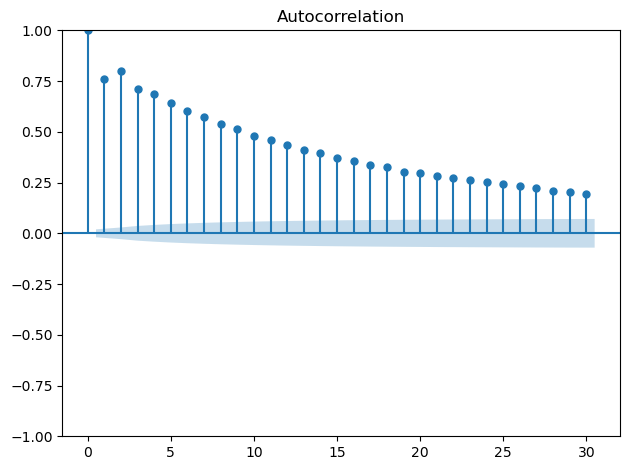

In [17]:
plot_acf(AR3_process, lags=30);

plt.tight_layout()

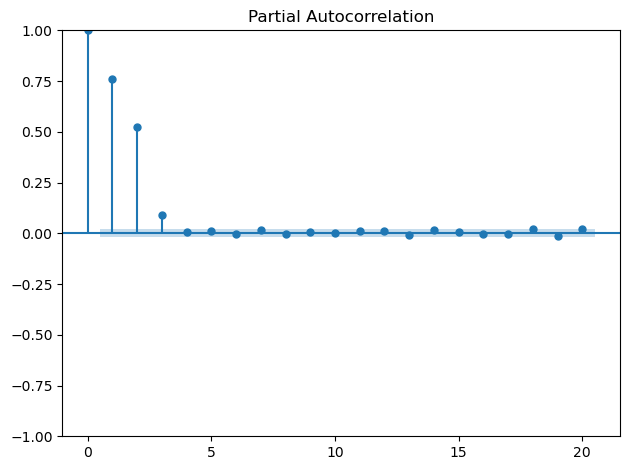

In [18]:
plot_pacf(AR3_process, lags=20);

plt.tight_layout()

In [19]:
AR3_df = pd.DataFrame({'value': AR3_process})

AR3_train = AR3_df[:-200]
AR3_test = AR3_df[-200:]

print(len(AR3_train))

9800


In [20]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [21]:
TRAIN_LEN = len(AR3_train)
HORIZON = len(AR3_test)
WINDOW = 2

pred_mean = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(AR3_df, TRAIN_LEN, HORIZON, WINDOW, 'AR')

AR3_test['pred_mean'] = pred_mean
AR3_test['pred_last_value'] = pred_last_value
AR3_test['pred_AR'] = pred_AR

AR3_test.head()

,value,pred_mean,pred_last_value,pred_AR
9800,0.251942,-0.019215,-1.360546,-0.654957
9801,-0.127163,-0.019215,-1.360546,-0.918610
9802,2.294406,-0.019199,-0.127163,-0.037953
9803,-0.304373,-0.019199,-0.127163,-0.051933
9804,1.860432,-0.018992,-0.304373,1.024416


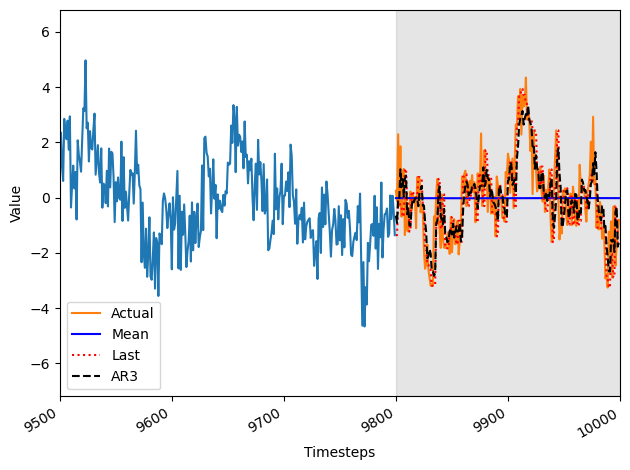

In [22]:
fig, ax = plt.subplots()

ax.plot(AR3_train)
ax.plot(AR3_test['value'], label='Actual')
ax.plot(AR3_test['pred_mean'], 'b-', label='Mean')
ax.plot(AR3_test['pred_last_value'], 'r:', label='Last')
ax.plot(AR3_test['pred_AR'], 'k--', label='AR3')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

plt.xlim(9500, 10000)
fig.autofmt_xdate()
plt.tight_layout()

In [23]:
mse_mean = mean_squared_error(AR3_test['value'], AR3_test['pred_mean'])
mse_last = mean_squared_error(AR3_test['value'], AR3_test['pred_last_value'])
mse_AR = mean_squared_error(AR3_test['value'], AR3_test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

2.136445934005893 1.2881802521489663 0.9969940312385074


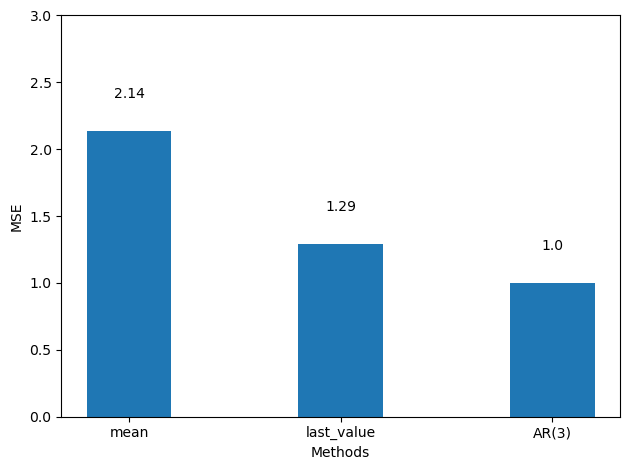

In [24]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()